## Kai Yang
## <kai.yang2 "at" mail.mcgill.ca>
## License :: OSI Approved :: GNU Affero General Public License v3 or later (AGPLv3+)
## [GPG Public key Fingerprint: CC02CF153594774CF956691492B2600D18170329](https://keys.openpgp.org/vks/v1/by-fingerprint/CC02CF153594774CF956691492B2600D18170329)

In [1]:
import multiprocess as _mp
import ctypes as _ctypes
from sklearn.preprocessing import RobustScaler as _scaler
from sklearn.decomposition import PCA as _PCA
from KDEpy.bw_selection import silvermans_rule as _silvermans_rule
from KDEpy.bw_selection import improved_sheather_jones as _improved_sheather_jones
from KDEpy.bw_selection import scotts_rule as _scotts_rule
from sklearn.feature_selection import mutual_info_regression as _mutual_info_regression
from sklearn.feature_selection import mutual_info_classif as _mutual_info_classif
from dask import dataframe as _dd
import pandas as _pd
from KDEpy import FFTKDE as _FFTKDE
# from bed_reader import open_bed as _open_bed
from numba import njit as _njit
from numba import jit as _jit
import numpy as _np
from tqdm import tqdm as _tqdm
import warnings as _warnings

_warnings.filterwarnings('ignore')

# basic functions

In [2]:
def _open_bed():
    print(
        "bed_reader might have some bugs for this version, causing it not running"
    )
    pass

In [3]:
%load_ext cython

In [4]:
%%cython -a
from libc.math cimport log, isfinite
from libc.stdlib cimport calloc, free
cimport cython
from cython cimport floating
from cython.parallel import prange

ctypedef fused floating_float_double:
    float
    double

@cython.boundscheck(False)
@cython.wraparound(False)
def joint_to_mi_cython(floating_float_double[:, ::1] joint, floating_float_double forward_euler_a=1., floating_float_double forward_euler_b=1.):
    cdef int i, j
    cdef int joint_shape0 = joint.shape[0]
    cdef int joint_shape1 = joint.shape[1]
    cdef floating_float_double *log_a_marginal = <floating_float_double*>calloc(joint_shape0, sizeof(floating_float_double))
    cdef floating_float_double *log_b_marginal = <floating_float_double*>calloc(joint_shape1, sizeof(floating_float_double))
    cdef floating_float_double temp_sum, log_val, log_temp_sum, log_forward_euler_a, log_forward_euler_b, log_joint, output

    if log_a_marginal == NULL or log_b_marginal == NULL:
        raise MemoryError("Failed to allocate memory.")

    temp_sum = 0.0
    for i in prange(joint_shape0, nogil=True):
        for j in range(joint_shape1):
            log_a_marginal[i] += joint[i, j]
            log_b_marginal[j] += joint[i, j]
        temp_sum += log_a_marginal[i]
    temp_sum *= forward_euler_a * forward_euler_b
    log_temp_sum = log(temp_sum)
    log_forward_euler_a = log(forward_euler_a)
    log_forward_euler_b = log(forward_euler_b)

    for i in prange(joint_shape0, nogil=True):
        log_val = log(log_a_marginal[i])
        log_a_marginal[i] = log_val + log_forward_euler_b if isfinite(log_val) else 0.0
    for j in prange(joint_shape1, nogil=True):
        log_val = log(log_b_marginal[j])
        log_b_marginal[j] = log_val + log_forward_euler_a if isfinite(log_val) else 0.0

    output = 0.0
    for i in prange(joint_shape0, nogil=True):
        for j in range(joint_shape1):
            log_joint = log(joint[i, j]) if isfinite(log(joint[i, j])) else 0.0
            output += joint[i, j] * (log_joint - log_a_marginal[i] - log_b_marginal[j]) * forward_euler_a * forward_euler_b

    output = max(output, 0.0)

    free(log_a_marginal)
    free(log_b_marginal)

    return output


In [5]:
# @_njit(cache=True)
def _nan_inf_to_0(x):
    """
    To convert NaN to 0 in nopython mode.
    """
    return _np.where(_np.isfinite(x), x, 0.)


# @_njit(cache=True)
def _joint_to_mi(joint, forward_euler_a=1., forward_euler_b=1.):
    # assume that joint likelihood is of shape (len(a), len(b))
    # forward_euler step being 1. means discrete r.v.
    # to scale the cdf to 1.
    joint /= _np.sum(joint) * forward_euler_a * forward_euler_b
    log_a_marginal = _np.log(_np.sum(joint, 1)) + _np.log(forward_euler_b)
    log_a_marginal = _nan_inf_to_0(log_a_marginal)
    log_b_marginal = _np.log(_np.sum(joint, 0)) + _np.log(forward_euler_a)
    log_b_marginal = _nan_inf_to_0(log_b_marginal)
    log_joint = _np.log(joint)
    log_joint = _nan_inf_to_0(log_joint)
    mi_temp = _np.sum(
        joint *
        (log_joint - log_a_marginal.reshape(-1, 1) -
         log_b_marginal.reshape(1, -1))) * forward_euler_a * forward_euler_b

    # this is to ensure that estimated MI is positive, to solve an numerical issue
    mi_temp = _np.max(_np.array([mi_temp, 0.]))

    return mi_temp


def MI_continuous_012(a, b, N=500, kernel="epa", bw="silverman", **kwarg):
    """
    calculate mutual information between continuous outcome and an SNP variable of 0,1,2
    assume no missing data
    """
    # first estimate the pmf
    p0 = _np.count_nonzero(b == 0) / len(b)
    p1 = _np.count_nonzero(b == 1) / len(b)
    p2 = 1. - p0 - p1
    _a = _scaler().fit_transform(a.reshape(-1, 1)).flatten()
    # this step is just to get the boundary width for the joint density grid
    # the three conditional density estimates need to be evaluated on the joint density grid
    a_temp, _ = _FFTKDE(kernel=kernel, bw=bw, **kwarg).fit(data=_a).evaluate(N)
    # estimate cond density
    _b0 = (b == 0)
    if _np.count_nonzero(_b0) > 2:
        # here proceed to kde only if there are more than 5 data points
        y_cond_p0 = _FFTKDE(kernel=kernel, bw=bw, **kwarg).fit(data=_a[_b0])
    else:
        y_cond_p0 = _np.zeros_like
    _b1 = (b == 1)
    if _np.count_nonzero(_b1) > 2:
        y_cond_p1 = _FFTKDE(kernel=kernel, bw=bw, **kwarg).fit(data=_a[_b1])
    else:
        y_cond_p1 = _np.zeros_like
    _b2 = (b == 2)
    if _np.count_nonzero(_b2) > 2:
        y_cond_p2 = _FFTKDE(kernel=kernel, bw=bw, **kwarg).fit(data=_a[_b2])
    else:
        y_cond_p2 = _np.zeros_like
    joint = _np.zeros((N, 3))
    joint[:, 0] = y_cond_p0(a_temp) * p0
    joint[:, 1] = y_cond_p1(a_temp) * p1
    joint[:, 2] = y_cond_p2(a_temp) * p2
    forward_euler_step = a_temp[1] - a_temp[0]
    mask = joint < 0.
    joint[mask] = 0.

    joint = _np.ascontiguousarray(joint)

    mi_temp = joint_to_mi_cython(joint=joint,
                                 forward_euler_a=forward_euler_step)

    return mi_temp


# @_njit(cache=True)
def MI_binary_012(a, b):
    """
    calculate mutual information between binary outcome and an SNP variable of 0,1,2
    assume no missing data
    """
    return MI_012_012(a, b)


# @_njit(cache=True)
def MI_012_012(a, b):
    """
    calculate mutual information between two SNPs
    assume no missing data
    could be very useful for a MI-based clumping
    """
    # estimate the cond pmf
    joint = _np.zeros((3, 3))
    _b0 = (b == 0)
    joint[0, 0] = _np.count_nonzero(_np.logical_and(a == 0, _b0)) / len(a)
    joint[1, 0] = _np.count_nonzero(_np.logical_and(a == 1, _b0)) / len(a)
    joint[2, 0] = _np.count_nonzero(_np.logical_and(a == 2, _b0)) / len(a)
    _b1 = (b == 1)
    joint[0, 1] = _np.count_nonzero(_np.logical_and(a == 0, _b1)) / len(a)
    joint[1, 1] = _np.count_nonzero(_np.logical_and(a == 1, _b1)) / len(a)
    joint[2, 1] = _np.count_nonzero(_np.logical_and(a == 2, _b1)) / len(a)
    _b2 = (b == 2)
    joint[0, 2] = _np.count_nonzero(_np.logical_and(a == 0, _b2)) / len(a)
    joint[1, 2] = _np.count_nonzero(_np.logical_and(a == 1, _b2)) / len(a)
    joint[2, 2] = _np.count_nonzero(_np.logical_and(a == 2, _b2)) / len(a)

    joint = _np.ascontiguousarray(joint)

    mi_temp = joint_to_mi_cython(joint=joint)

    return mi_temp


def MI_continuous_continuous(a,
                             b,
                             a_N=300,
                             b_N=300,
                             kernel="epa",
                             bw="silverman",
                             norm=2,
                             **kwarg):
    """
    Calculate mutual information on bivariate continuous r.v..
    """
    _temp = _np.argsort(a)
    data = _np.hstack((a[_temp].reshape(-1, 1), b[_temp].reshape(-1, 1)))
    _data = _scaler().fit_transform(data)

    if bw == "silverman":
        bw1, bw2 = _silvermans_rule(_data[:,
                                          [0]]), _silvermans_rule(_data[:,
                                                                        [1]])
    elif bw == "scott":
        bw1, bw2 = _scotts_rule(_data[:, [0]]), _scotts_rule(_data[:, [1]])
    elif bw == "ISJ":
        bw1, bw2 = _improved_sheather_jones(
            _data[:, [0]]), _improved_sheather_jones(_data[:, [1]])

    data_scaled = _data / _np.array([bw1, bw2])

    grid, joint = _FFTKDE(kernel=kernel, norm=norm,
                          **kwarg).fit(_data).evaluate((a_N, b_N))

    joint = joint.reshape(b_N, -1).T
    # this gives joint as a (a_N * b_N, 2) array, following example: https://kdepy.readthedocs.io/en/latest/examples.html#the-effect-of-norms-in-2d
    a_forward_euler_step = grid[b_N, 0] - grid[0, 0]
    b_forward_euler_step = grid[1, 1] - grid[0, 1]
    mask = joint < 0.
    joint[mask] = 0.

    joint = _np.ascontiguousarray(joint)

    mi_temp = joint_to_mi_cython(joint=joint,
                                 forward_euler_a=a_forward_euler_step,
                                 forward_euler_b=b_forward_euler_step)

    return mi_temp


def MI_binary_continuous(a, b, N=500, kernel="epa", bw="silverman", **kwarg):
    return MI_continuous_012(a=b, b=a, N=N, kernel=kernel, bw=bw, **kwarg)


@_njit(cache=True)
def Pearson_to_MI_Gaussian(corr):
    """
    Assuming the input variables are bivariate Gaussian, convert their Pearson correlatin to mutual information.
    """
    return -.5 * (_np.log(1 + corr) + _np.log(1 - corr))


@_njit(cache=True)
def MI_to_Linfoot(mi):
    """
    Convert calcualted mutual information estimator to Linfoot's measure of association.
    """
    return (1. - _np.exp(-2. * mi))**.5

In [6]:
# Cython is faster than Python implementation on many platforms I've tested this on, even in our case of massive vectorization
a, b = _np.random.rand(10000), _np.random.rand(3000)
joint = a * b.reshape(-1, 1)
%timeit joint_to_mi_cython(joint)
%timeit _joint_to_mi(joint)

# note that here the "joint" is nothing but a random matrix we generated -- it suffices to show the
joint_to_mi_cython(joint) - _joint_to_mi(joint)

195 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
297 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.0

# For `plink` files

In [7]:
# outcome_iid should be a  list of strings for identifiers
def continuous_screening_plink(bed_file,
                               bim_file,
                               fam_file,
                               outcome,
                               outcome_iid,
                               N=500,
                               kernel="epa",
                               bw="silverman",
                               verbose=1,
                               **kwarg):
    """
    (Single Core version) take plink files to calculate the mutual information between the continuous outcome and many SNP variables.
    """
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]

    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _map_foo(j):
        _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
        _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
        _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
        _SNP = _SNP[_SNP != -127]  # remove missing SNP
        return MI_continuous_012(a=_outcome,
                                 b=_SNP,
                                 N=N,
                                 kernel=kernel,
                                 bw=bw,
                                 **kwarg)

    _iter = range(len(bed1_sid))
    if verbose > 1:
        _iter = _tqdm(iter)
    MI_UKBB = _np.array(list(map(_map_foo, _iter)))
    return MI_UKBB


def binary_screening_plink(bed_file,
                           bim_file,
                           fam_file,
                           outcome,
                           outcome_iid,
                           verbose=1,
                           **kwarg):
    """
    (Single Core version) take plink files to calculate the mutual information between the binary outcome and many SNP variables.
    """
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _map_foo(j):
        _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
        _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
        _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
        _SNP = _SNP[_SNP != -127]  # remove missing SNP
        return MI_binary_012(a=_outcome, b=_SNP, **kwarg)

    _iter = range(len(bed1_sid))
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_UKBB = _np.array(list(map(_map_foo, _iter)))
    return MI_UKBB


def continuous_screening_plink_parallel(bed_file,
                                        bim_file,
                                        fam_file,
                                        outcome,
                                        outcome_iid,
                                        N=500,
                                        kernel="epa",
                                        bw="silverman",
                                        core_num="NOT DECLARED",
                                        multp=10,
                                        verbose=1,
                                        **kwarg):
    """
    (Multiprocessing version) take plink files to calculate the mutual information between the continuous outcome and many SNP variables.
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read some metadata
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _continuous_screening_plink_slice(_slice):

        def _map_foo(j):
            _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
            _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
            _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
            _SNP = _SNP[_SNP != -127]  # remove missing SNP
            return MI_continuous_012(a=_outcome,
                                     b=_SNP,
                                     N=N,
                                     kernel=kernel,
                                     bw=bw,
                                     **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(len(bed1_sid))
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_UKBB = pl.map(_continuous_screening_plink_slice, _iter)
    MI_UKBB = _np.hstack(MI_UKBB)
    return MI_UKBB


def binary_screening_plink_parallel(bed_file,
                                    bim_file,
                                    fam_file,
                                    outcome,
                                    outcome_iid,
                                    core_num="NOT DECLARED",
                                    multp=10,
                                    verbose=1,
                                    **kwarg):
    """
    (Multiprocessing version) take plink files to calculate the mutual information between the binary outcome and many SNP variables.
    """
    # check basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read some metadata
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    gene_iid = _np.array(list(bed1.iid))
    bed1_sid = _np.array(list(bed1.sid))
    outcome = outcome[_np.intersect1d(outcome_iid,
                                      gene_iid,
                                      assume_unique=True,
                                      return_indices=True)[1]]
    # get genetic indices
    gene_ind = _np.intersect1d(gene_iid,
                               outcome_iid,
                               assume_unique=True,
                               return_indices=True)[1]

    def _binary_screening_plink_slice(_slice):

        def _map_foo(j):
            _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
            _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
            _outcome = outcome[_SNP != -127]  # remove missing SNP in outcome
            _SNP = _SNP[_SNP != -127]  # remove missing SNP
            return MI_binary_012(a=_outcome, b=_SNP, **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(len(bed1_sid))
    _iter = _np.array_split(ind, core_num * multp)
    if verbose > 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_UKBB = pl.map(_binary_screening_plink_slice, _iter)
    MI_UKBB = _np.hstack(MI_UKBB)
    return MI_UKBB


def clump_plink_parallel(bed_file,
                         bim_file,
                         fam_file,
                         clumping_threshold=Pearson_to_MI_Gaussian(.6),
                         num_SNPS_exam=_np.infty,
                         core_num="NOT DECLARED",
                         multp=10,
                         verbose=1):
    """
    (Multiprocessing version) take plink files to calculate the mutual information between the binary outcome and many SNP variables.
    """
    # check basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read some metadata
    bed1 = _open_bed(filepath=bed_file,
                     fam_filepath=fam_file,
                     bim_filepath=bim_file)
    bed1_sid = _np.array(list(bed1.sid))
    if num_SNPS_exam == _np.infty:
        num_SNPS_exam = len(bed1_sid) - 1
    keep_cols = _np.arange(
        len(bed1_sid))  # pruning by keeping all SNPS at the beginning
    _iter = _np.arange(num_SNPS_exam)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    for current_var_ind in _iter:  # note that here _iter and keep_cols don't need to agree, by the break command comes later
        if current_var_ind + 1 <= len(keep_cols):
            outcome = bed1.read(_np.s_[:, current_var_ind],
                                dtype=_np.int8).flatten()
            gene_ind = _np.where(outcome != -127)
            outcome = outcome[gene_ind]

            def _012_012_plink_slice(_slice):

                def _map_foo(j):
                    _SNP = bed1.read(_np.s_[:, j], dtype=_np.int8).flatten()
                    _SNP = _SNP[gene_ind]  # get gene iid also in outcome iid
                    _outcome = outcome[_SNP !=
                                       -127]  # remove missing SNP in outcome
                    _SNP = _SNP[_SNP != -127]  # remove missing SNP
                    return MI_012_012(a=_outcome, b=_SNP)

                _MI_slice = _np.array(list(map(_map_foo, _slice)))
                return _MI_slice

            # multiprocessing starts here
            ind = keep_cols[current_var_ind + 1:]
            __iter = _np.array_split(ind, core_num * multp)
            with _mp.Pool(core_num) as pl:
                MI_UKBB = pl.map(_012_012_plink_slice, __iter)
            MI_UKBB = _np.hstack(MI_UKBB)
            keep_cols = _np.hstack(
                (keep_cols[:current_var_ind + 1],
                 keep_cols[current_var_ind +
                           1:][MI_UKBB <= clumping_threshold]))
        else:
            break
    return current_var_ind, bed1_sid[keep_cols]

# For `csv` files

In [8]:
def _read_csv(csv_file, _usecols, csv_engine, parquet_file, sample, verbose=1):
    """
    Read a csv file using differnet engines. Use dask to read csv if low in memory.
    """
    assert csv_engine in [
        "dask", "pyarrow", "fastparquet", "c", "python"
    ], "Only dask and pandas csv engines or fastparquet are supported to read csv files."
    if _np.array(_usecols).size == 0:
        if verbose > 1:
            print(
                "Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size."
            )
        if csv_engine == "dask":
            _df = _dd.read_csv(csv_file, sample=sample)
            _usecols = _np.array(list(_df.columns)[1:])
        elif csv_engine in ["pyarrow", "c",
                            "python"]:  # these are pandas CSV engines
            _df = _pd.read_csv(csv_file,
                               encoding='unicode_escape',
                               engine=csv_engine)
            _usecols = _np.array(_df.columns.to_list()[1:])
        elif csv_engine == "fastparquet":
            _df = _pd.read_parquet(parquet_file, engine="fastparquet")
            _usecols = _np.array(_df.columns.to_list()[1:])
        if verbose > 1:
            print("Reading variable names from csv file finished.")
    else:
        _usecols = _np.array(_usecols)
        if csv_engine == "dask":
            _df = _dd.read_csv(csv_file, names=_usecols, sample=sample)
        elif csv_engine in ["pyarrow", "c", "python"]:
            _df = _pd.read_csv(csv_file,
                               encoding='unicode_escape',
                               usecols=_usecols,
                               engine=csv_engine)
        elif csv_engine == "fastparquet":
            _df = _pd.read_parquet(parquet_file,
                                   engine="fastparquet")[_usecols]
    return _df, _usecols


def _read_two_columns(_df, __, csv_engine):
    """
    Read two columns from a dataframe object, remove NaN. Use dask to read csv if low in memory.
    """
    if csv_engine == "dask":
        _ = _np.asarray(_df[__].dropna().compute())
    elif csv_engine in ["pyarrow", "c", "python",
                        "fastparquet"]:  # these are engines using pandas
        _ = _df[__].dropna().to_numpy()

    _a = _[:, 0].copy()  # such that _df won't be mutated
    _b = _[:, 1].copy()  # such that _df won't be mutated
    return _a, _b


def binary_screening_csv(csv_file="_",
                         _usecols=[],
                         N=500,
                         kernel="epa",
                         bw="silverman",
                         csv_engine="c",
                         parquet_file="_",
                         sample=256000,
                         verbose=1,
                         **kwarg):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    assert csv_file != "_" or parquet_file != "_", "CSV or parquet filepath should be declared"
    # outcome is the first variable by default; if other specifications are needed, put it the first item in _usecols
    # read csv
    _df, _usecols = _read_csv(csv_file=csv_file,
                              _usecols=_usecols,
                              csv_engine=csv_engine,
                              parquet_file=parquet_file,
                              sample=sample,
                              verbose=verbose)

    def _map_foo(j):
        __ = [
            _usecols[0], _usecols[j + 1]
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
        return MI_binary_continuous(a=_a,
                                    b=_b,
                                    N=N,
                                    kernel=kernel,
                                    bw=bw,
                                    **kwarg)

    _iter = _np.arange(len(_usecols) - 1)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_df = _np.array(list(map(_map_foo, _iter)))

    del _df

    return MI_df


def continuous_screening_csv(csv_file="_",
                             _usecols=[],
                             a_N=300,
                             b_N=300,
                             kernel="epa",
                             bw="silverman",
                             norm=2,
                             csv_engine="c",
                             parquet_file="_",
                             sample=256000,
                             verbose=1,
                             **kwarg):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    assert csv_file != "_" or parquet_file != "_", "CSV or parquet filepath should be declared"
    # read csv
    _df, _usecols = _read_csv(csv_file=csv_file,
                              _usecols=_usecols,
                              csv_engine=csv_engine,
                              parquet_file=parquet_file,
                              sample=sample,
                              verbose=verbose)

    def _map_foo(j):
        __ = [
            _usecols[0], _usecols[j + 1]
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
        return MI_continuous_continuous(a=_a,
                                        b=_b,
                                        a_N=a_N,
                                        b_N=b_N,
                                        kernel=kernel,
                                        bw=bw,
                                        norm=norm,
                                        **kwarg)

    _iter = _np.arange(len(_usecols) - 1)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_df = _np.array(list(map(_map_foo, _iter)))

    del _df

    return MI_df


def binary_screening_csv_parallel(csv_file="_",
                                  _usecols=[],
                                  N=500,
                                  kernel="epa",
                                  bw="silverman",
                                  core_num="NOT DECLARED",
                                  multp=10,
                                  csv_engine="c",
                                  parquet_file="_",
                                  sample=256000,
                                  verbose=1,
                                  share_memory=True,
                                  **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert csv_file != "_" or parquet_file != "_", "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(csv_file=csv_file,
                              _usecols=_usecols,
                              csv_engine=csv_engine,
                              parquet_file=parquet_file,
                              sample=sample,
                              verbose=verbose)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return MI_binary_continuous(a=_a,
                                        b=_b,
                                        N=N,
                                        kernel=kernel,
                                        bw=bw,
                                        **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here

    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def continuous_screening_csv_parallel(csv_file="_",
                                      _usecols=[],
                                      a_N=300,
                                      b_N=300,
                                      kernel="epa",
                                      bw="silverman",
                                      norm=2,
                                      core_num="NOT DECLARED",
                                      multp=10,
                                      csv_engine="c",
                                      parquet_file="_",
                                      sample=256000,
                                      verbose=1,
                                      share_memory=True,
                                      **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert csv_file != "_" or parquet_file != "_", "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(csv_file=csv_file,
                              _usecols=_usecols,
                              csv_engine=csv_engine,
                              parquet_file=parquet_file,
                              sample=sample,
                              verbose=verbose)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return MI_continuous_continuous(a=_a,
                                            b=_b,
                                            a_N=a_N,
                                            b_N=b_N,
                                            kernel=kernel,
                                            bw=bw,
                                            norm=norm,
                                            **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def binary_skMI_screening_csv_parallel(csv_file="_",
                                       _usecols=[],
                                       n_neighbors=3,
                                       core_num="NOT DECLARED",
                                       multp=10,
                                       csv_engine="c",
                                       parquet_file="_",
                                       sample=256000,
                                       verbose=1,
                                       share_memory=True,
                                       **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be binary. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert csv_file != "_" or parquet_file != "_", "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(csv_file=csv_file,
                              _usecols=_usecols,
                              csv_engine=csv_engine,
                              parquet_file=parquet_file,
                              sample=sample,
                              verbose=verbose)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_skMI_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return _mutual_info_classif(y=_a.reshape(-1, 1),
                                        X=_b.reshape(-1, 1),
                                        n_neighbors=n_neighbors,
                                        discrete_features=False,
                                        **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_skMI_df_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def continuous_skMI_screening_csv_parallel(csv_file="_",
                                           _usecols=[],
                                           n_neighbors=3,
                                           core_num="NOT DECLARED",
                                           multp=10,
                                           csv_engine="c",
                                           parquet_file="_",
                                           sample=256000,
                                           verbose=1,
                                           share_memory=True,
                                           **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.
    """
    # check some basic things
    assert csv_file != "_" or parquet_file != "_", "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(csv_file=csv_file,
                              _usecols=_usecols,
                              csv_engine=csv_engine,
                              parquet_file=parquet_file,
                              sample=sample,
                              verbose=verbose)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_skMI_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return _mutual_info_regression(y=_a.reshape(-1, 1),
                                           X=_b.reshape(-1, 1),
                                           n_neighbors=n_neighbors,
                                           discrete_features=False,
                                           **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_skMI_df_slice, _iter)
    MI_df = _np.hstack(MI_df)

    del _df

    return MI_df


def Pearson_screening_csv_parallel(csv_file="_",
                                   _usecols=[],
                                   core_num="NOT DECLARED",
                                   multp=10,
                                   csv_engine="c",
                                   parquet_file="_",
                                   sample=256000,
                                   verbose=1,
                                   share_memory=True):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the Pearson's correlation between outcome and covariates.
    If _usecols is given, the returned Pearson correlation will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    This function accounts for missing data better than the Pearson's correlation matrix function provided by numpy.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.    """
    # check some basic things
    assert csv_file != "_" or parquet_file != "_", "CSV or parquet filepath should be declared"

    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    # read csv
    _df, _usecols = _read_csv(csv_file=csv_file,
                              _usecols=_usecols,
                              csv_engine=csv_engine,
                              parquet_file=parquet_file,
                              sample=sample,
                              verbose=verbose)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _Pearson_screening_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            # returned Pearson correlation is a symmetric matrix
            _a -= _np.mean(_a)
            _a /= _np.std(_a)
            _b -= _np.mean(_b)
            _b /= _np.std(_b)
            #             return _np.corrcoef(_a, _b)[0, 1]
            return _a @ _b / len(_a)

        _pearson_slice = _np.array(list(map(_map_foo, _slice)))
        return _pearson_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        Pearson_df = pl.map(_Pearson_screening_df_slice, _iter)
    Pearson_df = _np.hstack(Pearson_df)

    del _df

    return Pearson_df


def clump_continuous_csv_parallel(
        csv_file="_",
        _usecols=[],
        a_N=300,
        b_N=300,
        kernel="epa",
        bw="silverman",
        norm=2,
        clumping_threshold=Pearson_to_MI_Gaussian(.6),
        num_vars_exam=_np.infty,
        core_num="NOT DECLARED",
        multp=10,
        csv_engine="c",
        parquet_file="_",
        sample=256000,
        verbose=1,
        share_memory=True,
        **kwarg):
    """
    Perform clumping based on mutual information thresholding
    The clumping process starts from the left to right, preserve input variables under the clumping threshold
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.    """
    # initialization
    _, keep_cols = _read_csv(csv_file=csv_file,
                             _usecols=_usecols,
                             csv_engine="dask",
                             parquet_file=parquet_file,
                             sample=sample,
                             verbose=verbose)

    del _

    if num_vars_exam == _np.infty:
        num_vars_exam = len(keep_cols) - 1
    _iter = _np.arange(num_vars_exam)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    for current_var_ind in _iter:  # note that here _iter and keep_cols don't need to agree, by the break command comes later
        if current_var_ind + 1 <= len(keep_cols):
            _MI = continuous_screening_csv_parallel(
                csv_file=csv_file,
                _usecols=keep_cols[current_var_ind:],
                core_num=core_num,
                multp=multp,
                csv_engine=csv_engine,
                parquet_file=parquet_file,
                sample=sample,
                verbose=0,
                share_memory=share_memory,
                **kwarg)
            # current_var_ind + 1 since the current variable will be included anyway
            keep_cols = _np.hstack(
                (keep_cols[:current_var_ind + 1],
                 keep_cols[current_var_ind + 1:][_MI <= clumping_threshold]))
        else:
            break
    return current_var_ind, keep_cols

## DataFrame version

In [9]:
def binary_screening_dataframe(dataframe="_",
                               _usecols=[],
                               N=500,
                               kernel="epa",
                               bw="silverman",
                               csv_engine="c",
                               verbose=1,
                               **kwarg):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    def _map_foo(j):
        __ = [
            _usecols[0], _usecols[j + 1]
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
        return MI_binary_continuous(a=_a,
                                    b=_b,
                                    N=N,
                                    kernel=kernel,
                                    bw=bw,
                                    **kwarg)

    _iter = _np.arange(len(_usecols) - 1)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_df = _np.array(list(map(_map_foo, _iter)))

    return MI_df


def continuous_screening_dataframe(dataframe="_",
                                   _usecols=[],
                                   a_N=300,
                                   b_N=300,
                                   kernel="epa",
                                   bw="silverman",
                                   norm=2,
                                   csv_engine="c",
                                   verbose=1,
                                   **kwarg):
    """
    Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    """
    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    def _map_foo(j):
        __ = [
            _usecols[0], _usecols[j + 1]
        ]  # here using _usecol[j + 1] because the left first column is the outcome
        _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
        return MI_continuous_continuous(a=_a,
                                        b=_b,
                                        a_N=a_N,
                                        b_N=b_N,
                                        kernel=kernel,
                                        bw=bw,
                                        norm=norm,
                                        **kwarg)

    _iter = _np.arange(len(_usecols) - 1)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_df = _np.array(list(map(_map_foo, _iter)))

    return MI_df


def binary_screening_dataframe_parallel(dataframe="_",
                                        _usecols=[],
                                        N=500,
                                        kernel="epa",
                                        bw="silverman",
                                        core_num="NOT DECLARED",
                                        multp=10,
                                        csv_engine="c",
                                        verbose=1,
                                        share_memory=True,
                                        **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return MI_binary_continuous(a=_a,
                                        b=_b,
                                        N=N,
                                        kernel=kernel,
                                        bw=bw,
                                        **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here

    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def continuous_screening_dataframe_parallel(dataframe="_",
                                            _usecols=[],
                                            a_N=300,
                                            b_N=300,
                                            kernel="epa",
                                            bw="silverman",
                                            norm=2,
                                            core_num="NOT DECLARED",
                                            multp=10,
                                            csv_engine="c",
                                            verbose=1,
                                            share_memory=True,
                                            **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_screening_csv_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return MI_continuous_continuous(a=_a,
                                            b=_b,
                                            a_N=a_N,
                                            b_N=b_N,
                                            kernel=kernel,
                                            bw=bw,
                                            norm=norm,
                                            **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_screening_csv_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def binary_skMI_screening_dataframe_parallel(dataframe="_",
                                             _usecols=[],
                                             n_neighbors=3,
                                             core_num="NOT DECLARED",
                                             multp=10,
                                             csv_engine="c",
                                             verbose=1,
                                             share_memory=True,
                                             **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be binary. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _binary_skMI_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return _mutual_info_classif(y=_a.reshape(-1, 1),
                                        X=_b.reshape(-1, 1),
                                        n_neighbors=n_neighbors,
                                        discrete_features=False,
                                        **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_binary_skMI_df_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def continuous_skMI_screening_dataframe_parallel(dataframe="_",
                                                 _usecols=[],
                                                 n_neighbors=3,
                                                 core_num="NOT DECLARED",
                                                 multp=10,
                                                 csv_engine="c",
                                                 verbose=1,
                                                 share_memory=True,
                                                 **kwarg):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the mutual information between outcome and covariates.
    Both the outcome and the covariates should be continuous. 
    If _usecols is given, the returned mutual information will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _continuous_skMI_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            return _mutual_info_regression(y=_a.reshape(-1, 1),
                                           X=_b.reshape(-1, 1),
                                           n_neighbors=n_neighbors,
                                           discrete_features=False,
                                           **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_df = pl.map(_continuous_skMI_df_slice, _iter)
    MI_df = _np.hstack(MI_df)

    return MI_df


def Pearson_screening_dataframe_parallel(dataframe="_",
                                         _usecols=[],
                                         core_num="NOT DECLARED",
                                         multp=10,
                                         csv_engine="c",
                                         verbose=1,
                                         share_memory=True):
    """
    (Multiprocessing version) Take a (potentionally large) csv file to calculate the Pearson's correlation between outcome and covariates.
    If _usecols is given, the returned Pearson correlation will match _usecols. 
    By default, the left first covariate should be the outcome -- use _usecols to adjust if not the case.
    This function accounts for missing data better than the Pearson's correlation matrix function provided by numpy.
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.    
    """
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    # share_memory for multiprocess
    if share_memory == True:
        # the origingal dataframe is df, store the columns/dtypes pairs
        df_dtypes_dict = dict(list(zip(_df.columns, _df.dtypes)))
        # declare a shared Array with data from df
        mparr = _mp.Array(_ctypes.c_double, _df.values.reshape(-1))
        # create a new df based on the shared array
        _df = _pd.DataFrame(_np.frombuffer(mparr.get_obj()).reshape(_df.shape),
                            columns=_df.columns).astype(df_dtypes_dict)

    def _Pearson_screening_df_slice(_slice):

        def _map_foo(j):
            __ = [
                _usecols[0], _usecols[j]
            ]  # here using _usecol[j] because only input variables indices were splitted
            _a, _b = _read_two_columns(_df=_df, __=__, csv_engine=csv_engine)
            # returned Pearson correlation is a symmetric matrix
            _a -= _np.mean(_a)
            _a /= _np.std(_a)
            _b -= _np.mean(_b)
            _b /= _np.std(_b)
            #             return _np.corrcoef(_a, _b)[0, 1]
            return _a @ _b / len(_a)

        _pearson_slice = _np.array(list(map(_map_foo, _slice)))
        return _pearson_slice

    # multiprocessing starts here
    ind = _np.arange(
        1, len(_usecols)
    )  # starting from 1 because the first left column should be the outcome

    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        Pearson_df = pl.map(_Pearson_screening_df_slice, _iter)
    Pearson_df = _np.hstack(Pearson_df)

    return Pearson_df


def clump_continuous_dataframe_parallel(
        dataframe="_",
        _usecols=[],
        a_N=300,
        b_N=300,
        kernel="epa",
        bw="silverman",
        norm=2,
        clumping_threshold=Pearson_to_MI_Gaussian(.6),
        num_vars_exam=_np.infty,
        core_num="NOT DECLARED",
        multp=10,
        csv_engine="c",
        verbose=1,
        share_memory=True,
        **kwarg):
    """
    Perform clumping based on mutual information thresholding
    The clumping process starts from the left to right, preserve input variables under the clumping threshold
    share_memory is to indicate whether to share the dataframe in memory to 
    multiple processes -- if set to False, each process will copy the entire dataframe respectively. However, 
    to read very large dataframe using dask, this option should usually be turned off.    """
    # initialization
    _df = dataframe
    if _np.array(_usecols).size == 0:
        _usecols = _np.array(_df.columns.to_list()[1:])
    else:
        _usecols = _np.array(_usecols)

    if num_vars_exam == _np.infty:
        num_vars_exam = len(keep_cols) - 1
    _iter = _np.arange(num_vars_exam)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    for current_var_ind in _iter:  # note that here _iter and keep_cols don't need to agree, by the break command comes later
        if current_var_ind + 1 <= len(keep_cols):
            _MI = continuous_screening_dataframe_parallel(
                dataframe=dataframe,
                _usecols=keep_cols[current_var_ind:],
                core_num=core_num,
                multp=multp,
                csv_engine=csv_engine,
                parquet_file=parquet_file,
                sample=sample,
                verbose=0,
                share_memory=share_memory,
                **kwarg)
            # current_var_ind + 1 since the current variable will be included anyway
            keep_cols = _np.hstack(
                (keep_cols[:current_var_ind + 1],
                 keep_cols[current_var_ind + 1:][_MI <= clumping_threshold]))
        else:
            break
    return current_var_ind, keep_cols

# For numpy arrays

In [10]:
def binary_screening_array(X,
                           y,
                           drop_na=True,
                           N=500,
                           kernel="epa",
                           bw="silverman",
                           verbose=1,
                           **kwarg):
    """
    Take a numpy file to calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner. 
    """

    def _map_foo(j):
        _a, _b = y.copy(), X[:, j].copy()
        if drop_na == True:
            _keep = _np.logical_not(
                _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
            _a, _b = _a[_keep], _b[_keep]
        return MI_binary_continuous(a=_a,
                                    b=_b,
                                    N=N,
                                    kernel=kernel,
                                    bw=bw,
                                    **kwarg)

    _iter = _np.arange(X.shape[1])
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_array = _np.array(list(map(_map_foo, _iter)))
    return MI_array


def continuous_screening_array(X,
                               y,
                               drop_na=True,
                               a_N=300,
                               b_N=300,
                               kernel="epa",
                               bw="silverman",
                               norm=2,
                               verbose=1,
                               **kwarg):
    """
    Take a numpy file to calculate the mutual information between outcome and covariates.
    The outcome should be continuous and the covariates be continuous. 
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner. 
    """

    def _map_foo(j):
        _a, _b = y.copy(), X[:, j].copy()
        if drop_na == True:
            _keep = _np.logical_not(
                _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
            _a, _b = _a[_keep], _b[_keep]
        return MI_continuous_continuous(a=_a,
                                        b=_b,
                                        a_N=a_N,
                                        b_N=b_N,
                                        kernel=kernel,
                                        bw=bw,
                                        norm=norm,
                                        **kwarg)

    _iter = _np.arange(X.shape[1])
    if verbose >= 1:
        _iter = _tqdm(_iter)
    MI_array = _np.array(list(map(_map_foo, _iter)))
    return MI_array


def binary_screening_array_parallel(X,
                                    y,
                                    drop_na=True,
                                    N=500,
                                    kernel="epa",
                                    bw="silverman",
                                    core_num="NOT DECLARED",
                                    multp=10,
                                    verbose=1,
                                    **kwarg):
    """
    (Multiprocessing version) Calculate the mutual information between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner. 
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _binary_screening_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            return MI_binary_continuous(a=_a,
                                        b=_b,
                                        N=N,
                                        kernel=kernel,
                                        bw=bw,
                                        **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(
        X.shape[1]
    )  # starting from 1 because the first left column should be the outcome
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_binary_screening_csv_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array


def continuous_screening_array_parallel(X,
                                        y,
                                        drop_na=True,
                                        a_N=300,
                                        b_N=300,
                                        kernel="epa",
                                        bw="silverman",
                                        norm=2,
                                        core_num="NOT DECLARED",
                                        multp=10,
                                        verbose=1,
                                        **kwarg):
    """
    (Multiprocessing version) Calculate the mutual information between outcome and covariates.
    The outcome should be continuous and the covariates be continuous. 
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner. 
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _continuous_screening_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            return MI_continuous_continuous(a=_a,
                                            b=_b,
                                            a_N=a_N,
                                            b_N=b_N,
                                            kernel=kernel,
                                            bw=bw,
                                            norm=norm,
                                            **kwarg)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(X.shape[1])
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_continuous_screening_array_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array


def binary_skMI_array_parallel(X,
                               y,
                               drop_na=True,
                               n_neighbors=3,
                               core_num="NOT DECLARED",
                               multp=10,
                               verbose=1,
                               **kwarg):
    """
    (Multiprocessing version) Calculate the mutual information using sklearn implementation between outcome and covariates.
    The outcome should be binary and the covariates be binary. 
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner. 
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _binary_skMI_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            return _mutual_info_classif(y=_a.reshape(-1, 1),
                                        X=_b.reshape(-1, 1),
                                        n_neighbors=n_neighbors,
                                        discrete_features=False,
                                        **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(X.shape[1])
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_binary_skMI_array_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array


def continuous_skMI_array_parallel(X,
                                   y,
                                   drop_na=True,
                                   n_neighbors=3,
                                   core_num="NOT DECLARED",
                                   multp=10,
                                   verbose=1,
                                   **kwarg):
    """
    (Multiprocessing version) Calculate the mutual information using sklearn implementation between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner. 
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _continuous_skMI_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            return _mutual_info_regression(y=_a.reshape(-1, 1),
                                           X=_b.reshape(-1, 1),
                                           n_neighbors=n_neighbors,
                                           discrete_features=False,
                                           **kwarg)[0]

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(X.shape[1])
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_continuous_skMI_array_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array


def continuous_Pearson_array_parallel(X,
                                      y,
                                      drop_na=True,
                                      n_neighbors=3,
                                      core_num="NOT DECLARED",
                                      multp=10,
                                      verbose=1):
    """
    (Multiprocessing version) Calculate the mutual information using sklearn implementation between outcome and covariates.
    The outcome should be binary and the covariates be continuous. 
    If drop_na is set to be True, the NaN values will be dropped in a bivariate manner. 
    """
    # check some basic things
    if core_num == "NOT DECLARED":
        core_num = _mp.cpu_count()
    else:
        assert core_num <= _mp.cpu_count(
        ), "Declared number of cores used for multiprocessing should not exceed number of cores on this machine."
    assert core_num >= 2, "Multiprocessing should not be used on single-core machines."

    def _continuous_Pearson_array_slice(_slice):

        def _map_foo(j):
            _a, _b = y.copy(), X[:, j].copy()
            if drop_na == True:
                _keep = _np.logical_not(
                    _np.logical_or(_np.isnan(_a), _np.isnan(_b)))
                _a, _b = _a[_keep], _b[_keep]
            _a -= _np.mean(_a)
            _a /= _np.std(_a)
            _b -= _np.mean(_b)
            _b /= _np.std(_b)
            return _a @ _b / len(_a)

        _MI_slice = _np.array(list(map(_map_foo, _slice)))
        return _MI_slice

    # multiprocessing starts here
    ind = _np.arange(X.shape[1])
    _iter = _np.array_split(ind, core_num * multp)
    if verbose >= 1:
        _iter = _tqdm(_iter)
    with _mp.Pool(core_num) as pl:
        MI_array = pl.map(_continuous_Pearson_array_slice, _iter)
    MI_array = _np.hstack(MI_array)
    return MI_array

# Tests
## test for basic functions

In [11]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
# from bed_reader import open_bed
# import cupy as cp
from scipy.linalg import toeplitz, block_diag
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

a = np.random.binomial(2, .3, 2000)
b = np.random.binomial(2, .3, 2000)
print(
    "two independant generalized Bern. r.v. realisations has MI estimate of ",
    MI_binary_012(a, b))
print(
    "two independant generalized Bern. r.v. realisations has MI estimate of ",
    MI_012_012(a, b))

a = np.random.normal(size=2000)
b = np.random.normal(size=2000)

print(
    "two independant generalized Gaussian r.v. realisations has MI estimate of ",
    MI_continuous_continuous(a, b))
a_MI = np.zeros(500)
b_MI = np.zeros(500)
for i in np.arange(500):
    np.random.seed(i)
    a = np.random.normal(size=2000)
    b = np.random.normal(size=2000)
    a_MI[i] = MI_continuous_continuous(a, a)
    b_MI[i] = MI_continuous_continuous(a, b)
print("MI estimate between a,a and a,b: ", np.mean(a_MI), np.mean(b_MI))

two independant generalized Bern. r.v. realisations has MI estimate of  0.00048580978762792796
two independant generalized Bern. r.v. realisations has MI estimate of  0.00048580978762792796
two independant generalized Gaussian r.v. realisations has MI estimate of  0.0017658052604247142
MI estimate between a,a and a,b:  0.11484419275418552 0.0018941168050178234


## test for `plink` files

In [12]:
# # test for continuous screening on plink files
# bed_file = r"./fastHDMI/tests/sim/sim1.bed"
# bim_file = r"./fastHDMI/tests/sim/sim1.bim"
# fam_file = r"./fastHDMI/tests/sim/sim1.fam"

# _bed = open_bed(filepath=bed_file,
#                 fam_filepath=fam_file,
#                 bim_filepath=bim_file)
# outcome = np.random.rand(_bed.iid_count)
# outcome_iid = _bed.iid

# true_beta = np.array([4.2, -2.5, 2.6])
# for j in np.arange(3):
#     outcome += true_beta[j] * _bed.read(np.s_[:, j], dtype=np.int8).flatten()
#     print(_bed.read(np.s_[:, j], dtype=np.float64).flatten())

# iid_ind = np.random.permutation(np.arange(_bed.iid_count))
# outcome = outcome[iid_ind]
# outcome_iid = outcome_iid[iid_ind]

# MI_continuous = continuous_screening_plink_parallel(bed_file=bed_file,
#                                                     bim_file=bim_file,
#                                                     fam_file=fam_file,
#                                                     outcome=outcome,
#                                                     outcome_iid=outcome_iid, verbose=2)
# assert np.all(MI_continuous >= 0)

# plt.plot(MI_continuous)
# plt.show()

In [13]:
# # testing for binary plink files screening
# bed_file = r"./fastHDMI/tests/sim/sim1.bed"
# bim_file = r"./fastHDMI/tests/sim/sim1.bim"
# fam_file = r"./fastHDMI/tests/sim/sim1.fam"

# _bed = open_bed(filepath=bed_file,
#                 fam_filepath=fam_file,
#                 bim_filepath=bim_file)
# outcome = np.random.rand(_bed.iid_count)
# outcome_iid = _bed.iid

# true_beta = np.array([4.2, -2.5, 2.6])
# for j in np.arange(3):
#     outcome += true_beta[j] * _bed.read(np.s_[:, j], dtype=np.int8).flatten()
#     print(_bed.read(np.s_[:, j], dtype=np.float64).flatten())

# outcome = np.random.binomial(1, np.tanh(outcome / 2) / 2 + .5)

# iid_ind = np.random.permutation(np.arange(_bed.iid_count))
# outcome = outcome[iid_ind]
# outcome_iid = outcome_iid[iid_ind]

# MI_binary = binary_screening_plink_parallel(bed_file=bed_file,
#                                             bim_file=bim_file,
#                                             fam_file=fam_file,
#                                             outcome=outcome,
#                                             outcome_iid=outcome_iid, verbose=2)
# assert np.all(MI_binary >= 0)

# plt.plot(MI_binary)
# plt.show()

In [14]:
# # test for clumping for plink files
# bed_file = r"./fastHDMI/tests/sim/sim1.bed"
# bim_file = r"./fastHDMI/tests/sim/sim1.bim"
# fam_file = r"./fastHDMI/tests/sim/sim1.fam"

# clump_plink_parallel(bed_file=bed_file,
#                      bim_file=bim_file,
#                      fam_file=fam_file,
#                      num_SNPS_exam=5, verbose=2)

## test for `csv` files

In [15]:
# # This is to generate the test csv files
# import numpy as np
# from scipy.linalg import toeplitz, block_diag
# import pandas as pd

# np.random.seed(123)
# np.random.seed(np.around(np.random.rand(1) * 1e6, 3).astype(int))
# N = 1000
# SNR = 5.
# true_beta = np.array([2., -2., 8., -8.] + [0] * 2000)
# X_cov = toeplitz(.6**np.arange(true_beta.shape[0]))
# X_cov = np.asarray(X_cov)
# mean = (np.random.rand(true_beta.shape[0]) - .5) * 100
# X = np.random.multivariate_normal(mean, X_cov, N)
# X -= np.mean(X, 0).reshape(1, -1)
# X /= np.std(X, 0).reshape(1, -1)
# intercept_design_column = np.ones(N).reshape(N, 1)
# X_sim = np.concatenate((intercept_design_column, X), 1)
# true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
# true_beta_intercept = np.concatenate((np.array([0]), true_beta))
# y_sim = X_sim @ true_beta_intercept + np.random.normal(0, true_sigma_sim, N)
# X = X**2
# X -= np.mean(X, 0).reshape(1, -1)
# X /= np.std(X, 0).reshape(1, -1)
# X = np.concatenate((y_sim.reshape(-1, 1), X), 1)
# X.ravel()[np.random.choice(X.size, int(X.size * .1),
#                            replace=False)] = np.nan  # 10% missing data

# pd.DataFrame(X,
#              columns=map(lambda x: "Var " + str(x), np.arange(
#                  1, X.shape[1] +
#                  1))).to_csv(r"./fastHDMI/tests/sim/sim_continuous.csv")

# # this cell is for profiling the function
# np.random.seed(321)
# np.random.seed(np.around(np.random.rand(1) * 1e6, 3).astype(int))
# N = 1000
# SNR = 5.
# true_beta = np.array([.5, -.5, .8, -.8] + [0] * 2000)
# X_cov = toeplitz(.6**np.arange(true_beta.shape[0]))
# X_cov = np.asarray(X_cov)
# mean = (np.random.rand(true_beta.shape[0]) - .5) * 100
# X = np.random.multivariate_normal(mean, X_cov, N)
# X -= np.mean(X, 0).reshape(1, -1)
# X /= np.std(X, 0).reshape(1, -1)
# intercept_design_column = np.ones(N).reshape(N, 1)
# X_sim = np.concatenate((intercept_design_column, X), 1)
# true_sigma_sim = np.sqrt(true_beta.T @ X_cov @ true_beta / SNR)
# true_beta_intercept = np.concatenate((np.array([0]), true_beta))
# # + np.random.normal(0, true_sigma_sim, N)
# signal = X_sim @ true_beta_intercept
# y_sim = np.random.binomial(1, np.tanh(signal / 2) / 2 + .5)
# # X = X**2
# # X -= np.mean(X, 0).reshape(1, -1)
# # X /= np.std(X, 0).reshape(1, -1)
# X = np.concatenate((y_sim.reshape(-1, 1), X), 1)
# X.ravel()[np.random.choice(X.size, int(X.size * .1),
#                            replace=False)] = np.nan  # 10% missing data

# pd.DataFrame(X,
#              columns=map(lambda x: "Var " + str(x), np.arange(
#                  1, X.shape[1] +
#                  1))).to_csv(r"./fastHDMI/tests/sim/sim_binary.csv")

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|███████████████████████████████████████| 2004/2004 [00:20<00:00, 96.86it/s]


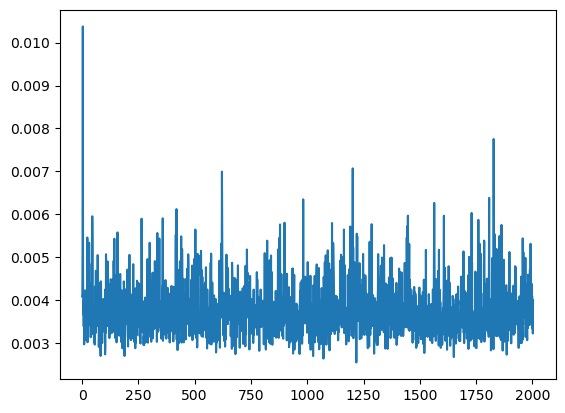

In [16]:
# single-thread continuous version test
a = continuous_screening_csv(r"./fastHDMI/tests/sim/sim_continuous.csv",
                             verbose=2)
assert np.all(a >= 0)

plt.plot(a)
plt.show()

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 31.77it/s]


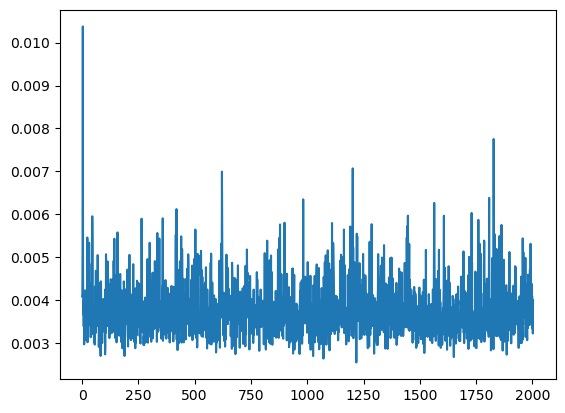

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 33.93it/s]


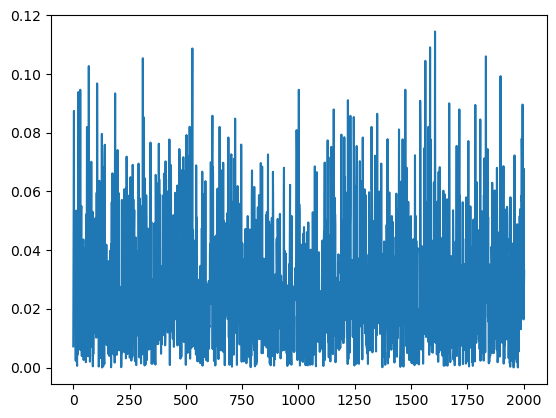

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 33.55it/s]


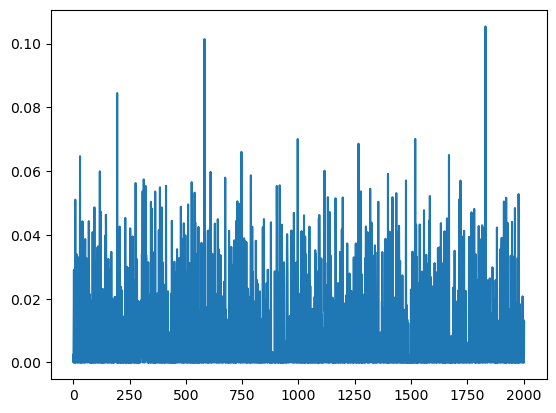

In [17]:
# parallel continuous version test XXX
a = continuous_screening_csv_parallel(
    r"./fastHDMI/tests/sim/sim_continuous.csv", verbose=2)
assert np.all(a >= 0)
plt.plot(a)
plt.show()

b = np.absolute(
    Pearson_screening_csv_parallel(r"./fastHDMI/tests/sim/sim_continuous.csv",
                                   verbose=2))
plt.plot(b)
plt.show()

c = continuous_skMI_screening_csv_parallel(
    r"./fastHDMI/tests/sim/sim_continuous.csv", random_state=0, verbose=2)
assert np.all(c >= 0)
plt.plot(c)
plt.show()

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|██████████████████████████████████████| 2004/2004 [00:03<00:00, 556.88it/s]

[0.00871107 0.00259809 0.00992829 ... 0.00319114 0.00400104 0.00271581]


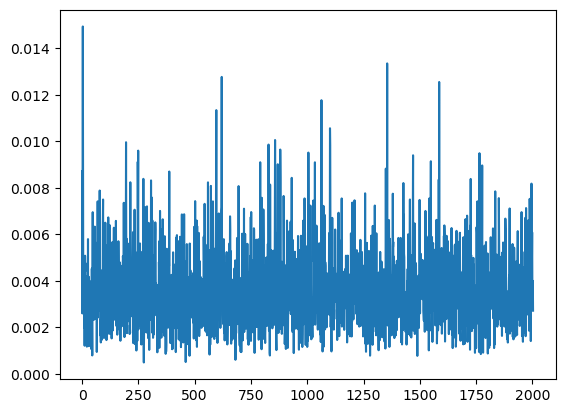

In [18]:
# single-thread binary version for csv
a = binary_screening_csv(r"./fastHDMI/tests/sim/sim_binary.csv", verbose=2)
print(a)
assert np.all(a >= 0)
plt.plot(a)
plt.show()

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 33.65it/s]


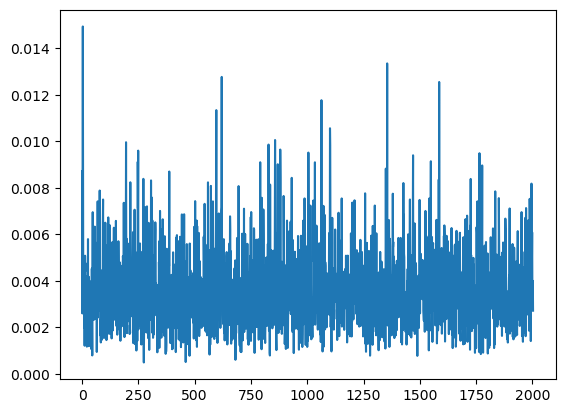

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 33.77it/s]


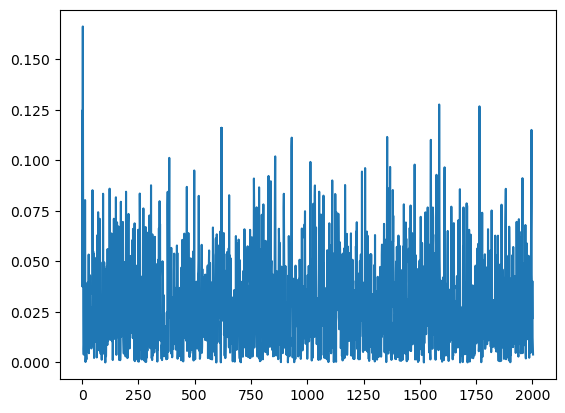

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████| 240/240 [00:07<00:00, 33.01it/s]


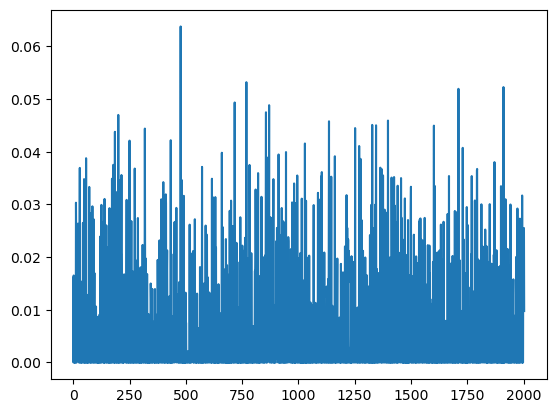

In [19]:
# parallel binary version test
a = binary_screening_csv_parallel(r"./fastHDMI/tests/sim/sim_binary.csv",
                                  verbose=2)
assert np.all(a >= 0)
plt.plot(a)
plt.show()

b = np.absolute(
    Pearson_screening_csv_parallel(r"./fastHDMI/tests/sim/sim_binary.csv",
                                   verbose=2))
plt.plot(b)
plt.show()

c = binary_skMI_screening_csv_parallel(r"./fastHDMI/tests/sim/sim_binary.csv",
                                       random_state=0,
                                       verbose=2)
assert np.all(c >= 0)
plt.plot(c)
plt.show()

In [20]:
# test for clumping for CSV files
clump_continuous_csv_parallel(
    csv_file=r"./fastHDMI/tests/sim/sim_continuous.csv",
    num_vars_exam=5,
    verbose=2)

Variable names not provided -- start reading variable names from csv file now, might take some time, depending on the csv file size.
Reading variable names from csv file finished.


100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.50s/it]


(4,
 array(['Var 1', 'Var 2', 'Var 3', ..., 'Var 2003', 'Var 2004', 'Var 2005'],
       dtype='<U8'))

## test for `np.array`

100%|█████████████████████████████████████████| 240/240 [00:02<00:00, 99.45it/s]


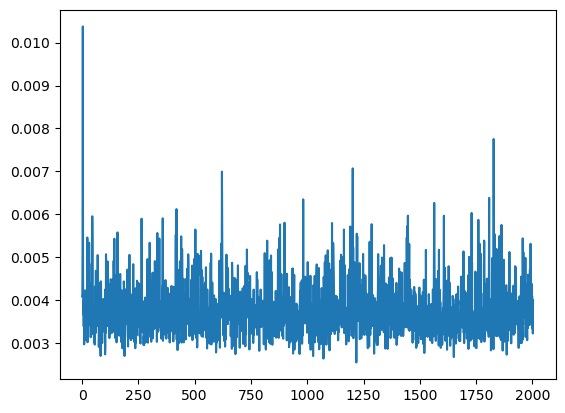

100%|████████████████████████████████████████| 240/240 [00:01<00:00, 191.66it/s]


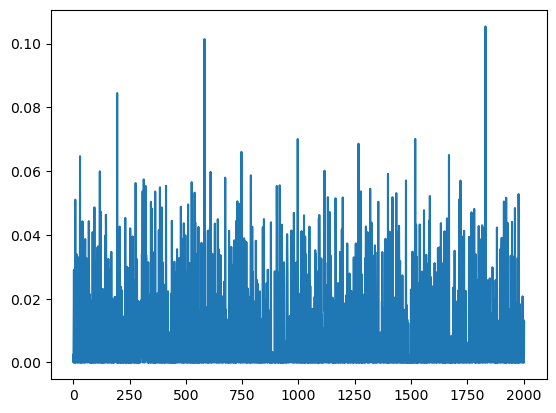

In [21]:
# parallel continuous version but using numpy array
csv = pd.read_csv(r"./fastHDMI/tests/sim/sim_continuous.csv",
                  encoding='unicode_escape',
                  engine="c")
# here it is because pandas reads the first column as the index
X, y = csv.iloc[:, 2:].to_numpy(), csv.iloc[:, 1].to_numpy()

MI = continuous_screening_array_parallel(X, y, verbose=2)
assert np.all(MI >= 0)
plt.plot(MI)
plt.show()

skMI = continuous_skMI_array_parallel(X,
                                      y,
                                      n_neighbors=3,
                                      random_state=0,
                                      verbose=2)
assert np.all(skMI >= 0)
plt.plot(skMI)
plt.show()